<a href="https://colab.research.google.com/github/tsaialice9/HW1_VAE_MNIST/blob/main/HW3_LSTM_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[LSTM] Epoch 1/10 | Train MSE: 12891.6363 | Valid MSE: 11258.3579
[LSTM] Epoch 2/10 | Train MSE: 9436.5217 | Valid MSE: 9557.5436
[LSTM] Epoch 3/10 | Train MSE: 8520.5580 | Valid MSE: 8875.8086
[LSTM] Epoch 4/10 | Train MSE: 8158.9108 | Valid MSE: 8553.9565
[LSTM] Epoch 5/10 | Train MSE: 7958.0619 | Valid MSE: 8319.2109
[LSTM] Epoch 6/10 | Train MSE: 7833.6513 | Valid MSE: 8139.8383
[LSTM] Epoch 7/10 | Train MSE: 7741.3033 | Valid MSE: 8115.4356
[LSTM] Epoch 8/10 | Train MSE: 7700.7428 | Valid MSE: 8092.6978
[LSTM] Epoch 9/10 | Train MSE: 7623.5425 | Valid MSE: 7909.9653
[LSTM] Epoch 10/10 | Train MSE: 7631.3577 | Valid MSE: 8010.4372
[VAE] Epoch 1/15 | Train Loss: 13356.5123 | Valid Loss: 11671.5393
[VAE] Epoch 2/15 | Train Loss: 9763.9879 | Valid Loss: 9843.9201
[VAE] Epoch 3/15 | Train Loss: 8719.2991 | Valid Loss: 9072.8507
[VAE] Epoch 4/15 | Train Loss: 8257.0546 | Valid Loss: 8643.6330
[VAE] Epoch 5/15 | Train Loss: 8015.9292 | Valid Loss: 8352.1044
[VAE] Epoch 6/15 | Train Loss:

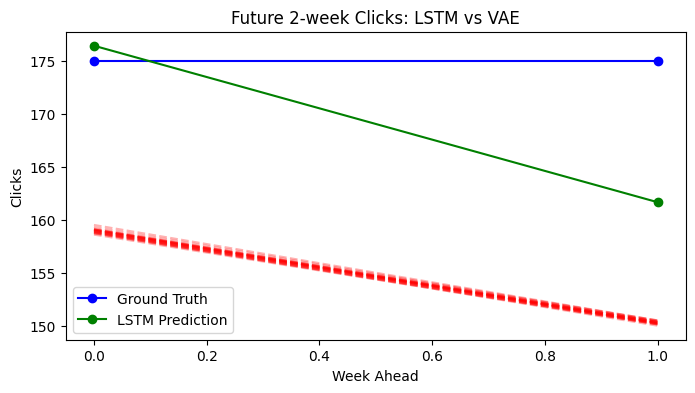

=== Win-rate by improvement bucket (Δ = LSTM MSE − VAE best MSE) ===
  Improvement bucket  count     ratio
0      VAE<<劣(>1000)   5605  0.094154
1     VAE劣(200~1000)   9097  0.152814
2       VAE劣(50~200)   8563  0.143843
3        VAE劣(10~50)   5682  0.095448
4         VAE略劣(<10)   1778  0.029867
5           ≈打平(±10)   3603  0.060524
6       VAE略勝(10~50)   4570  0.076768
7       VAE勝(50~200)   8350  0.140265
8    VAE大勝(200~1000)   8644  0.145204
9     VAE>>大勝(>1000)   5416  0.090979

=== Top-5 Regressed (VAE best > LSTM) ===
     idx      LSTM_MSE  VAE_best_MSE  Δ(LSTM-VAE)            y_true  \
0  31967  8.612821e+05  6.169962e+05  244285.8750  [1509.0, 1509.0]   
1  31965  8.612821e+05  6.169776e+05  244304.5000  [1509.0, 1509.0]   
2  49310  7.736516e+05  4.754406e+05  298210.9375  [1389.0, 1389.0]   
3  31960  9.889011e+05  6.393574e+05  349543.6875  [1509.0, 1509.0]   
4  39606  1.556984e+06  1.193594e+06  363389.2500  [1720.0, 1720.0]   

                   y_LSTM             y_VAE

In [2]:
# =====================================
#  Seq2Seq LSTM 與 VAE
# =====================================

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

# 固定隨機種子
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# =====================================
# 1️ 讀取資料
# =====================================
studentInfo = pd.read_csv('/content/studentInfo.csv')
studentVle = pd.read_csv('/content/studentVle.csv')
studentAssessment = pd.read_csv('/content/studentAssessment.csv')

# =====================================
# 2️ 建立每週 clicks
# =====================================
studentVle['week'] = studentVle['date'] // 7
weekly_clicks = studentVle.groupby(['id_student','week'])['sum_click'].sum().reset_index()
weekly_clicks.rename(columns={'sum_click':'clicks'}, inplace=True)

# =====================================
# 3️ 每週提交次數 & has_submit
# =====================================
studentAssessment['week'] = pd.to_datetime(studentAssessment['date_submitted'], errors='coerce').dt.day // 7
studentAssessment['week'] = studentAssessment['week'].fillna(-1).astype(int)
weekly_submit = studentAssessment[studentAssessment['week']>=0].groupby(['id_student','week']).size().reset_index(name='submit_cnt')
weekly_submit['has_submit'] = (weekly_submit['submit_cnt']>0).astype(int)

# =====================================
# 4️ 計算 avg_score_sofar
# =====================================
avg_scores = []
for sid, g in studentAssessment.groupby('id_student'):
    g = g.sort_values('week')
    g['avg_score_sofar'] = g['score'].expanding().mean()
    avg_scores.append(g[['id_student','week','avg_score_sofar']])
avg_scores_df = pd.concat(avg_scores)

# =====================================
# 5️ 合併特徵，計算 clicks_diff1
# =====================================
merged = weekly_clicks.merge(
    weekly_submit[['id_student','week','submit_cnt','has_submit']],
    on=['id_student','week'], how='left'
)
merged = merged.merge(avg_scores_df, on=['id_student','week'], how='left')
merged['submit_cnt'] = merged['submit_cnt'].fillna(0)
merged['has_submit'] = merged['has_submit'].fillna(0)
merged['avg_score_sofar'] = merged['avg_score_sofar'].fillna(0)
merged = merged.sort_values(['id_student','week'])
merged['clicks_diff1'] = merged.groupby('id_student')['clicks'].diff().fillna(0)

# =====================================
# 6️ 建立序列 (過去4週 → 預測2週 clicks)
# =====================================
def make_sequences(df, past=4, future=2):
    X, Y = [], []
    for sid, g in df.groupby('id_student'):
        g = g.sort_values('week')
        data = g[['clicks','submit_cnt','avg_score_sofar','clicks_diff1']].values
        if len(data) < past + future:
            continue
        for i in range(len(data) - past - future + 1):
            X.append(data[i:i+past])
            Y.append(data[i+past:i+past+future, 0])
    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)

X, Y = make_sequences(merged)

# =====================================
# 7️ 以學生 ID 切分 train/valid/test
# =====================================
student_ids = merged['id_student'].unique()
train_ids, test_ids = train_test_split(student_ids, test_size=0.2, random_state=seed)
valid_ids, test_ids = train_test_split(test_ids, test_size=0.5, random_state=seed)

def filter_by_ids(df, ids):
    sub_df = df[df['id_student'].isin(ids)]
    return make_sequences(sub_df)

X_train, Y_train = filter_by_ids(merged, train_ids)
X_valid, Y_valid = filter_by_ids(merged, valid_ids)
X_test, Y_test = filter_by_ids(merged, test_ids)

# =====================================
# 8️ Dataset & DataLoader
# =====================================
class SeqDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

BATCH_SIZE = 128
train_loader = DataLoader(SeqDataset(X_train, Y_train), batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(SeqDataset(X_valid, Y_valid), batch_size=BATCH_SIZE)
test_loader = DataLoader(SeqDataset(X_test, Y_test), batch_size=BATCH_SIZE)

# =====================================
# 9️ Seq2Seq LSTM
# =====================================
class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=64, output_len=2):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.decoder = nn.LSTM(1, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim,1)
        self.output_len = output_len

    def forward(self, x):
        _, (h, c) = self.encoder(x)
        dec_input = x[:, -1:, [0]]  # 上一週 clicks
        outputs = []
        for t in range(self.output_len):
            out, (h, c) = self.decoder(dec_input, (h, c))
            pred = self.fc_out(out)
            outputs.append(pred)
            dec_input = pred
        outputs = torch.cat(outputs, dim=1).squeeze(-1)
        return outputs

lstm_model = Seq2SeqLSTM().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)

# =====================================
# 10️ 訓練 LSTM
# =====================================
n_epochs = 10
for epoch in range(n_epochs):
    lstm_model.train()
    total_loss = 0
    for Xb, Yb in train_loader:
        Xb, Yb = Xb.to(device), Yb.to(device)
        optimizer.zero_grad()
        pred = lstm_model(Xb)
        loss = criterion(pred, Yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(Xb)
    avg_loss = total_loss / len(train_loader.dataset)

    # 驗證集 MSE
    lstm_model.eval()
    val_loss = 0
    with torch.no_grad():
        for Xb, Yb in valid_loader:
            Xb, Yb = Xb.to(device), Yb.to(device)
            pred = lstm_model(Xb)
            val_loss += criterion(pred, Yb).item() * len(Xb)
    val_loss /= len(valid_loader.dataset)
    print(f"[LSTM] Epoch {epoch+1}/{n_epochs} | Train MSE: {avg_loss:.4f} | Valid MSE: {val_loss:.4f}")

# =====================================
# 11️ Seq2Seq VAE
# =====================================
class Seq2SeqVAE(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=64, latent_dim=16, output_len=2):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.output_len = output_len
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.decoder_lstm = nn.LSTM(1 + latent_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, 1)

    def encode(self, x):
        _, (h, _) = self.encoder_lstm(x)
        h = h[-1]
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar, scale=2.0):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + scale * eps * std  # 增加隨機性

    def decode(self, z, y_init):
        batch_size = z.size(0)
        dec_input = y_init.unsqueeze(-1).unsqueeze(1)
        z_expand = z.unsqueeze(1)
        dec_input = torch.cat([dec_input, z_expand], dim=-1)
        h = torch.zeros(1, batch_size, self.hidden_dim).to(device)
        c = torch.zeros(1, batch_size, self.hidden_dim).to(device)
        outputs = []
        for t in range(self.output_len):
            out, (h, c) = self.decoder_lstm(dec_input, (h, c))
            pred = self.fc_out(out)
            outputs.append(pred)
            dec_input = torch.cat([pred, z_expand], dim=-1)
        outputs = torch.cat(outputs, dim=1).squeeze(-1)
        return outputs

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        y_init = x[:, -1, 0]
        out = self.decode(z, y_init)
        return out, mu, logvar

def vae_loss(pred, target, mu, logvar, beta=0.02):  # 增大 beta 提高多樣性
    MSE = nn.MSELoss()(pred, target)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + beta*KLD, MSE, KLD

vae_model = Seq2SeqVAE().to(device)
vae_optimizer = torch.optim.Adam(vae_model.parameters(), lr=1e-3)

# =====================================
# 12️ 訓練 VAE
# =====================================
n_epochs = 15
for epoch in range(n_epochs):
    vae_model.train()
    total_loss = 0
    for Xb, Yb in train_loader:
        Xb, Yb = Xb.to(device), Yb.to(device)
        vae_optimizer.zero_grad()
        pred, mu, logvar = vae_model(Xb)
        loss, mse, kld = vae_loss(pred, Yb, mu, logvar)
        loss.backward()
        vae_optimizer.step()
        total_loss += loss.item() * len(Xb)
    avg_loss = total_loss / len(train_loader.dataset)

    # 驗證
    vae_model.eval()
    val_loss = 0
    with torch.no_grad():
        for Xb, Yb in valid_loader:
            Xb, Yb = Xb.to(device), Yb.to(device)
            pred, mu, logvar = vae_model(Xb)
            loss, mse, kld = vae_loss(pred, Yb, mu, logvar)
            val_loss += loss.item() * len(Xb)
    val_loss /= len(valid_loader.dataset)
    print(f"[VAE] Epoch {epoch+1}/{n_epochs} | Train Loss: {avg_loss:.4f} | Valid Loss: {val_loss:.4f}")

# =====================================
# 13️ LSTM 單一路徑 & VAE 多樣化生成
# =====================================
# LSTM
lstm_model.eval()
all_lstm_preds, all_lstm_gts = [], []
with torch.no_grad():
    for Xb, Yb in test_loader:
        Xb, Yb = Xb.to(device), Yb.to(device)
        pred = lstm_model(Xb)
        all_lstm_preds.append(pred.cpu().numpy())
        all_lstm_gts.append(Yb.cpu().numpy())
all_lstm_preds = np.concatenate(all_lstm_preds, axis=0)
all_lstm_gts = np.concatenate(all_lstm_gts, axis=0)
lstm_mse = np.mean((all_lstm_preds - all_lstm_gts)**2)
print("LSTM MSE:", lstm_mse)

# VAE
N_samples = 20
vae_model.eval()
with torch.no_grad():
    Xb, Yb = next(iter(test_loader))
    Xb, Yb = Xb.to(device), Yb.to(device)
    all_samples = []
    for _ in range(N_samples):
        mu, logvar = vae_model.encode(Xb)
        z = vae_model.reparameterize(mu, logvar, scale=2.0)  # 放大噪聲
        y_init = Xb[:, -1, 0]
        pred = vae_model.decode(z, y_init)
        all_samples.append(pred.cpu().numpy())
all_samples = np.stack(all_samples, axis=0)
gt = Yb.cpu().numpy()
best_of_n_mse = np.mean(np.min(np.mean((all_samples - gt)**2, axis=-1), axis=0))
diversity = np.mean(np.std(all_samples, axis=0))
coverage = np.mean(np.max(all_samples, axis=0) >= gt)
print("VAE Best-of-N MSE:", best_of_n_mse)
print("VAE Diversity (std):", diversity)
print("VAE Coverage (ratio):", coverage)

# =====================================
# 14️ 可視化對比
# =====================================
plt.figure(figsize=(8,4))
plt.plot(range(2), gt[0], 'bo-', label='Ground Truth')
plt.plot(range(2), all_lstm_preds[0], 'g-o', label='LSTM Prediction')
for n in range(N_samples):
    plt.plot(range(2), all_samples[n,0], 'r--', alpha=0.3)
plt.title('Future 2-week Clicks: LSTM vs VAE')
plt.xlabel('Week Ahead')
plt.ylabel('Clicks')
plt.legend()
plt.show()
# =====================================
# 15️ 模型比較分析
# =====================================
from collections import Counter

vae_model.eval()
all_lstm_preds, all_vae_best, all_vae_std, all_gts = [], [], [], []

# 重新在整個 test set 比較每筆資料
with torch.no_grad():
    for Xb, Yb in test_loader:
        Xb, Yb = Xb.to(device), Yb.to(device)
        # LSTM 預測
        pred_lstm = lstm_model(Xb)
        # VAE 多樣本預測
        N_samples = 20
        preds = []
        for _ in range(N_samples):
            mu, logvar = vae_model.encode(Xb)
            z = vae_model.reparameterize(mu, logvar, scale=2.0)
            y_init = Xb[:, -1, 0]
            pred = vae_model.decode(z, y_init)
            preds.append(pred.cpu().numpy())
        preds = np.stack(preds, axis=0)  # [N, batch, seq_len]
        # Best-of-N: 取 MSE 最小者
        mse_all = np.mean((preds - Yb.cpu().numpy())**2, axis=-1)  # [N, batch]
        best_idx = np.argmin(mse_all, axis=0)
        best_preds = preds[best_idx, np.arange(len(best_idx))]
        std_preds = np.std(preds, axis=0).mean(axis=1)

        all_lstm_preds.append(pred_lstm.cpu().numpy())
        all_vae_best.append(best_preds)
        all_vae_std.append(std_preds)
        all_gts.append(Yb.cpu().numpy())

# 拼起來
all_lstm_preds = np.concatenate(all_lstm_preds, axis=0)
all_vae_best = np.concatenate(all_vae_best, axis=0)
all_vae_std = np.concatenate(all_vae_std, axis=0)
all_gts = np.concatenate(all_gts, axis=0)

# 每筆的 MSE
LSTM_MSE = np.mean((all_lstm_preds - all_gts)**2, axis=1)
VAE_best_MSE = np.mean((all_vae_best - all_gts)**2, axis=1)
delta = LSTM_MSE - VAE_best_MSE  # 正數代表 VAE 表現較好

# 統計
buckets = [
    ("VAE<<劣(>1000)", delta < -1000),
    ("VAE劣(200~1000)", (delta >= -1000) & (delta < -200)),
    ("VAE劣(50~200)", (delta >= -200) & (delta < -50)),
    ("VAE劣(10~50)", (delta >= -50) & (delta < -10)),
    ("VAE略劣(<10)", (delta >= -10) & (delta < 0)),
    ("≈打平(±10)", (delta >= -10) & (delta <= 10)),
    ("VAE略勝(10~50)", (delta > 10) & (delta <= 50)),
    ("VAE勝(50~200)", (delta > 50) & (delta <= 200)),
    ("VAE大勝(200~1000)", (delta > 200) & (delta <= 1000)),
    ("VAE>>大勝(>1000)", delta > 1000)
]

summary = []
for name, cond in buckets:
    count = np.sum(cond)
    ratio = count / len(delta)
    summary.append([name, count, ratio])

df_summary = pd.DataFrame(summary, columns=['Improvement bucket', 'count', 'ratio'])
print("=== Win-rate by improvement bucket (Δ = LSTM MSE − VAE best MSE) ===")
print(df_summary)

# 顯示 Top-5 改善最多的樣本
top_idx = np.argsort(delta)[-5:]
df_top5 = pd.DataFrame({
    'idx': top_idx,
    'LSTM_MSE': LSTM_MSE[top_idx],
    'VAE_best_MSE': VAE_best_MSE[top_idx],
    'Δ(LSTM-VAE)': delta[top_idx],
    'y_true': list(all_gts[top_idx]),
    'y_LSTM': list(all_lstm_preds[top_idx]),
    'y_VAE_best': list(all_vae_best[top_idx]),
    'Diversity_std': all_vae_std[top_idx]
})
print("\n=== Top-5 Regressed (VAE best > LSTM) ===")
print(df_top5)
